# Top 10 Active Drivers Report

## Overview
This Jupyter notebook generates a report showcasing the top 10 active drivers based on a combination of various driver metrics. The goal is to identify and highlight the best-performing drivers within the taxi service based on a holistic evaluation of their performance.

## Description
The metrics used for ranking the drivers include:

- **Endurance Score**: Measures the driver's ability to work long hours without a drop in performance.
- **Profitability Score**: Assesses how profitable a driver is for the company.
- **Safety Score**: Evaluates the driver's adherence to safety protocols.
- **Efficiency Score**: Gauges how efficiently the driver completes trips.
- **Recognition Score**: Reflects any special achievements or awards received by the driver.
- **Customer Satisfaction Score**: Based on the ratings given by customers.
- **Experience Score**: Accounts for the driver's overall experience in the field.


## Methodology
### Pillars of Driver Evaluation
The evaluation is based on four main pillars:

#### 1. Operational Metrics:
**Endurance Score**: Weighted at 20%. This score measures the driver's ability to maintain performance over long hours.

**Profitability Score**: Weighted at 40%. This score assesses the financial efficiency and profitability of the driver.

**Efficiency Score**: Weighted at 30%. This score gauges the driver's ability to complete trips efficiently.

**Safety Score**: Weighted at 50%. This score evaluates the driver's adherence to safety protocols.

##### Weightings
The weightings reflect the priority of each operational goal, with safety being our highest priority.


##### Calculation
The operational score is calculated as follows:

  ```python
  operational_score = (
      (df['driver_endurance_score'] * 20 +
        df['driver_profitabilty_score'] * 40 +
        df['driver_safety_adherence_score'] * 50 +
        df['driving_efficiency_score'] * 30) / 100
  )
  ```

#### 2. Recognition:
**Recognition Score**: Reflects any special achievements or awards received by the driver. This score is scaled to a maximum of 100%. If a driver has special achievements, they receive a score of 100, otherwise 0.
    
  ```python
  recognition_score = df['special_achievements_awarded'].apply(lambda x: 100 if x else 0)
  ```

#### 3. Customer Satisfaction:
**Customer Satisfaction Score**: Based on customer ratings, this score is calculated as a weighted average of star ratings (from 1 to 5 stars), converted to a percentage and clipped between 0 and 100.
    
  ```python
  customer_satisfaction_score = (
      (df['number_of_1_star_ratings'] * 0.2 +
        df['number_of_2_star_ratings'] * 0.4 +
        df['number_of_3_star_ratings'] * 0.6 +
        df['number_of_4_star_ratings'] * 0.8 +
        df['number_of_5_star_ratings'] * 1.0) /
      (df['number_of_1_star_ratings'] +
        df['number_of_2_star_ratings'] +
        df['number_of_3_star_ratings'] +
        df['number_of_4_star_ratings'] +
        df['number_of_5_star_ratings']) * 100
  )
  customer_satisfaction_score = customer_satisfaction_score.clip(lower=0, upper=100)
  ```

#### 4. Experience:
**Experience Score**: This score is based on the driver's experience group and is scaled to a maximum of 100%.

  ```python
  experience_score = df['driver_experience_group'] * 10
  ```

### Combined Score Calculation
The final combined score is an average of the four pillar scores. This score is used to rank the drivers.

  ```python
  df['combined_score'] = (operational_score + recognition_score + customer_satisfaction_score + experience_score) / 4
  ```

### Installs

In [1]:
!pip install datapane

### Imports

In [2]:
import pandas as pd
import numpy as np
import datapane as dp
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm

### Functions

In [3]:
# Function to filter active drivers
def filter_active_drivers(df):
    """
    Filters the DataFrame to include only active drivers.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing driver data.

    Returns:
    pd.DataFrame: A DataFrame with only active drivers.
    """

    active_drivers = df[(df['deleted'] == False) & (df['disabled'] == False)]

    return active_drivers

In [4]:
# Function to calculate the combined score

def calculate_combined_score(df):
    """
    Calculates the combined score for drivers based on multiple metrics, including operational metrics,
    recognition, customer satisfaction, and driver experience.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing driver data.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'combined_score' column.
    """

    # Operational metrics (weighted by priority)
    # Converted normalized values to a percentage
    operational_score = (
        (df['driver_endurance_score'] * 20 +
         df['driver_profitabilty_score'] * 40 +
         df['driver_safety_adherence_score'] * 50 +
         df['driving_efficiency_score'] * 30) / 100 )

    # Recognition - soft skills
    # Scale to a maximum score of 20 (representing 100%), then multiply by 5 to convert to a percentage
    recognition_score = df['special_achievements_awarded'].apply(lambda x: 100 if x else 0)

    # Customer satisfaction
    # Calculate the weighted average of the star ratings and convert it to a percentage
    customer_satisfaction_score = (
        (df['number_of_1_star_ratings'] * 0.2 +
        df['number_of_2_star_ratings'] * 0.4 +
        df['number_of_3_star_ratings'] * 0.6 +
        df['number_of_4_star_ratings'] * 0.8 +
        df['number_of_5_star_ratings'] * 1.0)
        /
        (df['number_of_1_star_ratings'] +
          df['number_of_2_star_ratings'] +
          df['number_of_3_star_ratings'] +
          df['number_of_4_star_ratings'] +
          df['number_of_5_star_ratings'])
        * 100
    )

    # Ensure customer satisfaction is represented as a percentage
    # Clip values to ensure they are between 0 and 100
    customer_satisfaction_score = customer_satisfaction_score.clip(lower=0, upper=100)

    # Driver experience
    # as a percentage
    experience_score = (df['driver_experience_group']) * 10

    # Combined score
    # as a percentage
    df['combined_score'] = (operational_score + recognition_score + customer_satisfaction_score + experience_score) / 4

    # Other scores
    df['operational_score'] = operational_score
    df['recognition_score'] = recognition_score
    df['customer_satisfaction_score'] = customer_satisfaction_score
    df['experience_score'] = experience_score

    return df

In [5]:
# Function to convert scores to percentages
def convert_to_percentage(df, columns):
    for column in columns:
        # Shift data to make all values positive
        min_val = df[column].min()
        df[column] = df[column] - min_val

        # Determine the range
        max_val = df[column].max()

        # Normalize the data to 0-1 range
        df[column] = df[column] / max_val

        # Convert to percentage
        df[column] = df[column] * 100

    return df

In [6]:
def get_top_n_drivers(df, n, sort_by):
    """
    Returns the top n drivers based on the specified sorting column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing driver data.
    n (int): The number of top drivers to return.
    sort_by (str): The column name to sort by.

    Returns:
    pd.DataFrame: A DataFrame with the top n drivers.
    """

    top_drivers = df.sort_values(by=sort_by, ascending=False).head(n)

    return top_drivers

In [7]:
# REUSED

def rename_columns(df, column_mapping):
    """
    Rename the columns of the DataFrame based on the provided mappings.

    Parameters:
    df (pd.DataFrame): The input DataFrame with original column names.

    Returns:
    pd.DataFrame: The DataFrame with renamed columns.

    """

    # Rename the columns
    df = df.rename(columns=column_mapping)

    return df

In [8]:
# REUSED

def reorder_columns(df, desired_columns_order):
    """
    Reorder the columns of the DataFrame according to the desired order.

    Parameters:
        df (pandas.DataFrame): The DataFrame whose columns are to be reordered.
        desired_columns_order (list): The desired order of columns.

    Returns:
        pandas.DataFrame: DataFrame with columns reordered according to the desired order.

    """
    # Reorder the columns of the DataFrame
    df = df.reindex(columns=desired_columns_order)

    return df

In [9]:
def save_plot_for_each_pillar(top_10_df, pillars):
    """
    Generates and saves bar plots for each pillar score for the top 10 drivers.

    Parameters:
    top_10_df (pd.DataFrame): DataFrame containing the scores for the top 10 drivers.
    pillars (list): List of column names representing the individual pillars.

    Returns:
    None
    """
    for pillar in pillars:
        # Define the width of the bars
        bar_width = 0.4

        # Set the index for the bars
        index = np.arange(len(top_10_df))

        # Create a figure and axis object
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get a random colormap
        colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(top_10_df)))

        # Plot the metric as a set of bars
        ax.bar(index,
               top_10_df[pillar],
               bar_width,
               label=pillar,
               color=colors)

        # Add value labels above each bar
        for i, value in enumerate(top_10_df[pillar]):
            ax.text(i, value + 0.1, str(round(value, 2)), ha='center', va='bottom')

        # Set the x-axis ticks and labels
        ax.set_xticks(index)
        ax.set_xticklabels(top_10_df['Driver Full Name'], rotation=45, ha='right')  # Display driver's full name

        # Add labels and legend
        ax.set_xlabel('Drivers')
        ax.set_ylabel('Score (%)')
        ax.set_title(f'Top 10 Drivers by {pillar}')
        ax.legend()

        # Set a custom y-axis range for each set of bars
        min_score = top_10_df[pillar].min()
        max_score = top_10_df[pillar].max()
        y_range = max_score - min_score

        # Handle case where y_range is zero
        if y_range == 0:
            ax.set_ylim(min_score - 1, max_score + 1)
        else:
            ax.set_ylim(min_score - 0.1 * y_range, max_score + 0.1 * y_range)

        # Save plot to disk
        filename = os.path.join("./", f'{pillar}_plot.png')
        plt.tight_layout()  # Adjust layout to prevent clipping
        plt.savefig(filename)

        # Close plot to prevent memory leaks
        plt.close()

In [10]:
def plot_driver_scores_all_pillars(top_10_df, pillars):
    """
    Plots the scores for the top 10 drivers across all specified pillars and the overall combined score.

    Parameters:
    top_10_df (pd.DataFrame): DataFrame containing the scores for the top 10 drivers.
    pillars (list): List of column names representing the individual pillars.

    Returns:
    plt: The generated plot.
    """
    # Sort the DataFrame by the overall combined score
    top_10_df = top_10_df.sort_values(by='Overall Combined (%)', ascending=False)

    # Set the positions and width for the bars
    bar_width = 0.2
    gap = 0.2  # Gap between groups
    index = np.arange(len(top_10_df)) * (len(pillars) + 1) * (bar_width + gap)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Generate random colors for the bars
    colors = np.random.rand(len(pillars) + 1, 3)

    # Plot each pillar as a separate set of bars
    for i, pillar in enumerate(pillars):
        ax.bar(index + bar_width * i, top_10_df[pillar], bar_width, label=pillar, color=colors[i])

        # Add value labels above each bar
        for j, value in enumerate(top_10_df[pillar]):
            ax.text(index[j] + bar_width * i, value + 0.1, str(round(value, 2)), ha='center', va='bottom')

    # Plot the combined score
    combined_score_values = top_10_df['Overall Combined (%)']
    combined_score_labels = [f'{round(value, 2)}' for value in combined_score_values]

    combined_bars = ax.bar(index + bar_width * len(pillars), combined_score_values, bar_width, label='Overall Combined (%)', color=colors[-1])

    # Add value labels above each combined score bar
    for bar, label in zip(combined_bars, combined_score_labels):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, label, ha='center', va='bottom', color='black')

    # Setting the x-axis labels
    ax.set_xlabel('Drivers')
    ax.set_ylabel('Scores (%)')
    ax.set_title('Top 10 Active Drivers by Overall Combined Score and the Pillars of Excellence')
    ax.set_xticks(index + bar_width * len(pillars) / 2)
    ax.set_xticklabels(top_10_df['Driver Full Name'], rotation=45, ha='right')

    # Adding legend
    ax.legend()

    # Set a flexible y-axis range to zoom in on subtle differences
    min_score = min(top_10_df[pillars].values.min(), combined_score_values.min())
    max_score = max(top_10_df[pillars].values.max(), combined_score_values.max())
    y_range = max_score - min_score
    ax.set_ylim(min_score - 0.1 * y_range, max_score + 0.1 * y_range)

    # Adjust layout and save plot
    plt.tight_layout()
    plt.savefig('plot_driver_scores_all_pillars.png')
    plt.show()
    plt.close()

    return plt



In [11]:
def plot_driver_scores_combined(top_10_df):
    """
    Plots the overall combined score for the top 10 drivers.

    Parameters:
    top_10_df (pd.DataFrame): DataFrame containing the scores for the top 10 drivers.

    Returns:
    None
    """
    # Sort the DataFrame by the overall combined score
    top_10_df = top_10_df.sort_values(by='Overall Combined (%)', ascending=False)

    # Set the positions and width for the bars
    index = np.arange(len(top_10_df))
    bar_width = 0.5

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Get random colors for each bar
    colors = np.random.rand(len(top_10_df), 3)

    # Plot the combined score
    combined_score_values = top_10_df['Overall Combined (%)']
    combined_score_labels = [f'{round(value, 2)}' for value in combined_score_values]

    bars = ax.bar(index, combined_score_values, bar_width, color=colors)

    # Add value labels above each bar
    for bar, label in zip(bars, combined_score_labels):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, label, ha='center', va='bottom')

    # Set the x-axis ticks and labels
    ax.set_xlabel('Drivers')
    ax.set_ylabel('Scores (%)')
    ax.set_title('Top 10 Active Drivers Overall Combined Score')
    ax.set_xticks(index)
    ax.set_xticklabels(top_10_df['Driver Full Name'], rotation=45, ha='right')

    # Set a flexible y-axis range to zoom in on subtle differences
    min_score = combined_score_values.min()
    max_score = combined_score_values.max()
    y_range = max_score - min_score
    ax.set_ylim(min_score - 0.1 * y_range, max_score + 0.1 * y_range)

    # Show plot
    plt.tight_layout()
    plt.savefig('plot_driver_scores_combined.png')
    plt.show()
    plt.close()

    return plt

### Data Structure Configurations

In [12]:
# REUSED:

# Define the desired order of columns
desired_columns_order = [
    'taxi_group_name', 'rank', 'full_name', 'vehicle_brand', 'driver_experience_group',
    'special_achievements_awarded', 'driver_endurance_score', 'driver_profitabilty_score',
    'driver_safety_adherence_score', 'driving_efficiency_score',
    'number_of_1_star_ratings', 'number_of_2_star_ratings', 'number_of_3_star_ratings',
    'number_of_4_star_ratings', 'number_of_5_star_ratings'
]

In [13]:
# REUSED:

# Define the mapping from old column names to new column names
column_mapping = {
    'taxi_group_name': 'Taxi Group Name',
    'rank': 'Taxi Division Rank',
    'full_name': 'Driver Full Name',
    'vehicle_brand': 'Vehicle Brand',
    'driver_experience_group': 'Experience Group',
    'special_achievements_awarded': 'Special Awards',
    'driver_endurance_score': 'Endurance Score',
    'driver_profitabilty_score': 'Profitability Score',
    'driver_safety_adherence_score': 'Safety Score',
    'driving_efficiency_score': 'Efficiency Score',
    'number_of_1_star_ratings': '#of1Star Ratings',
    'number_of_2_star_ratings': '#of2Star Ratings',
    'number_of_3_star_ratings': '#of3Star Ratings',
    'number_of_4_star_ratings': '#of4Star Ratings',
    'number_of_5_star_ratings': '#of5Star Ratings'
}

In [14]:
columns_to_convert = [
    'driver_endurance_score',
    'driver_profitabilty_score',
    'driver_safety_adherence_score',
    'driving_efficiency_score'
]

In [15]:
pillars = [
    'Operational (%)',
    'Recognition (%)',
    'Customer Satisfaction (%)',
    'Experience Score (%)'
]

In [16]:
report_header = """
# 2a. Top 10 Active Drivers Awards

## Introduction
Welcome to the inaugural Top 10 Drivers Awards, our first year hosting this prestigious event. The competition has been incredibly fierce, with drivers separated by infinitesimal percentage points across each of our four pillars. To ensure transparency, let us explain our methodology behind the four pillars and why they are paramount in determining our top drivers.
"""

In [17]:
methodology = """
## Methodology
### Pillars of Excellence
The evaluation is based on four main pillars:

#### 1. Operational Metrics:
**Endurance Score**: Weighted at 20%. This score measures the driver's ability to maintain performance over long hours.

**Profitability Score**: Weighted at 40%. This score assesses the financial efficiency and profitability of the driver.

**Efficiency Score**: Weighted at 30%. This score gauges the driver's ability to complete trips efficiently.

**Safety Score**: Weighted at 50%. This score evaluates the driver's adherence to safety protocols.

##### Weightings
The weightings reflect the priority of each operational goal, with safety being our highest priority.


##### Calculation
The operational score is calculated as follows:

  ```python
  operational_score = (
      (df['driver_endurance_score'] * 20 +
        df['driver_profitabilty_score'] * 40 +
        df['driver_safety_adherence_score'] * 50 +
        df['driving_efficiency_score'] * 30) / 100
  )
  ```

#### 2. Recognition:
**Recognition Score**: Reflects any special achievements or awards received by the driver. This score is scaled to a maximum of 100%. If a driver has special achievements, they receive a score of 100, otherwise 0.

  ```python
  recognition_score = df['special_achievements_awarded'].apply(lambda x: 100 if x else 0)
  ```

#### 3. Customer Satisfaction:
**Customer Satisfaction Score**: Based on customer ratings, this score is calculated as a weighted average of star ratings (from 1 to 5 stars), converted to a percentage and clipped between 0 and 100.

  ```python
  customer_satisfaction_score = (
      (df['number_of_1_star_ratings'] * 0.2 +
        df['number_of_2_star_ratings'] * 0.4 +
        df['number_of_3_star_ratings'] * 0.6 +
        df['number_of_4_star_ratings'] * 0.8 +
        df['number_of_5_star_ratings'] * 1.0) /
      (df['number_of_1_star_ratings'] +
        df['number_of_2_star_ratings'] +
        df['number_of_3_star_ratings'] +
        df['number_of_4_star_ratings'] +
        df['number_of_5_star_ratings']) * 100
  )
  customer_satisfaction_score = customer_satisfaction_score.clip(lower=0, upper=100)
  ```

#### 4. Experience:
**Experience Score**: This score is based on the driver's experience group and is scaled to a maximum of 100%.

  ```python
  experience_score = df['driver_experience_group'] * 10
  ```

### Combined Score Calculation
The final combined score is an average of the four pillar scores. This score is used to rank the drivers.

  ```python
  df['combined_score'] = (operational_score + recognition_score + customer_satisfaction_score + experience_score) / 4
  ```
"""

### Execute

#### Build the Result Set

In [18]:
# Load the data from the pickle file
df = pd.read_pickle('data2.pkl')

# Convert the specified columns to percentages
df = convert_to_percentage(df, columns_to_convert)

# Use the calculate_combined_score function to add the combined score to the DataFrame
df = calculate_combined_score(df)

# Use the filter_active_drivers function to get active drivers
active_drivers = filter_active_drivers(df)

# Get the top 10 active drivers based on the combined score
top_10_drivers = get_top_n_drivers(active_drivers, 10, 'combined_score')

In [19]:
# Align Column Names to Instructions ---

# NOTES:
# - Reusing previous column names configs + functions
# - Could turn these steps into seperate step of functions for a seperate stage in pipeline (TODO)
# - Impractical in this assignment exercise right now...

# Append 'combined_score' to the desired columns order list
desired_columns_order.append("combined_score")
desired_columns_order.append("operational_score")
desired_columns_order.append("recognition_score")
desired_columns_order.append("customer_satisfaction_score")
desired_columns_order.append("experience_score")

# Reorder columns to the desired order
# Note: some fields are dropped
top_10_drivers = reorder_columns(top_10_drivers, desired_columns_order)

# Append new mapping for "combined_score"
column_mapping['combined_score'] = 'Overall Combined (%)'
column_mapping['operational_score'] = 'Operational (%)'
column_mapping['recognition_score'] = 'Recognition (%)'
column_mapping['customer_satisfaction_score'] = 'Customer Satisfaction (%)'
column_mapping['experience_score'] = 'Experience Score (%)'

# Rename columns to the desired names
top_10_drivers = rename_columns(top_10_drivers, column_mapping)



In [20]:
top_10_drivers.head()
top_10_drivers.loc[:,['Driver Full Name',
                      'Overall Combined (%)',
                      'Operational (%)',
                      'Recognition (%)',
                      'Customer Satisfaction (%)',
                      'Experience Score (%)']].head(10)


,Driver Full Name,Overall Combined (%),Operational (%),Recognition (%),Customer Satisfaction (%),Experience Score (%)
109,Jessica Burns,80.655947,73.532879,100,89.090909,60
2346,Karen Fry,80.652296,73.251385,100,89.357798,60
4706,Emily Wilson,80.584843,72.865690,100,89.473684,60
33428,Glen Hopkins,80.506804,72.904408,100,89.122807,60
43859,Yvonne Palmer,80.403985,73.297357,100,88.318584,60
39916,Matthew White,80.397617,73.733323,100,87.857143,60
26361,Carly Edwards,80.344942,72.134485,100,89.245283,60
24955,Jeffrey French,80.340744,72.791547,100,88.571429,60
9109,Jayne Jones,80.309997,72.489989,100,88.750000,60
33461,Karl Williams,80.301550,73.098092,100,88.108108,60


In [21]:
# Sort top_10_df by 'Overall Combined (%)'
top_10_drivers = top_10_drivers.sort_values(by='Overall Combined (%)', ascending=False)


#### Generate Report

In [22]:
save_plot_for_each_pillar(top_10_drivers, pillars)

<ipython-input-9-bc860484886c>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20')(np.linspace(0, 1, len(top_10_df)))


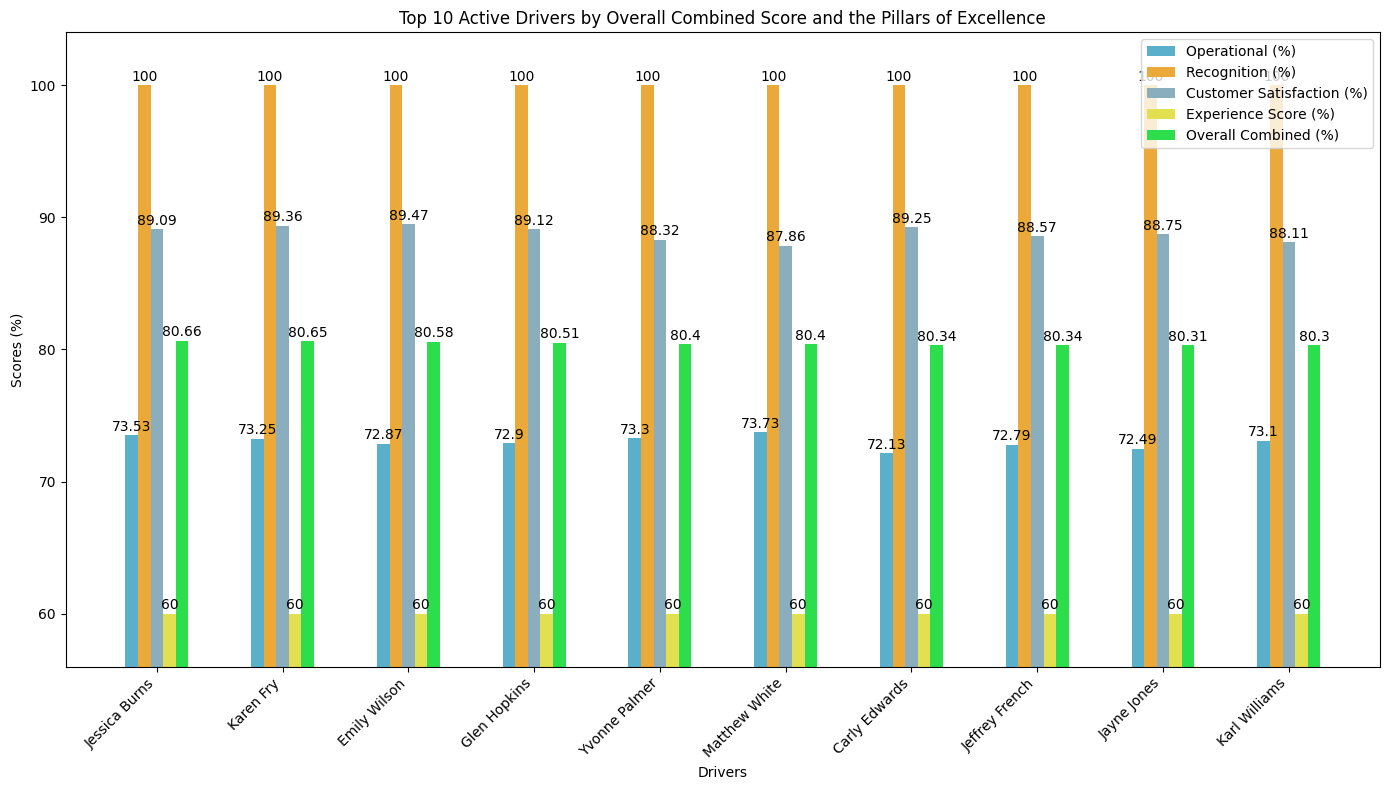

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [23]:
plot_driver_scores_all_pillars(top_10_drivers, pillars)

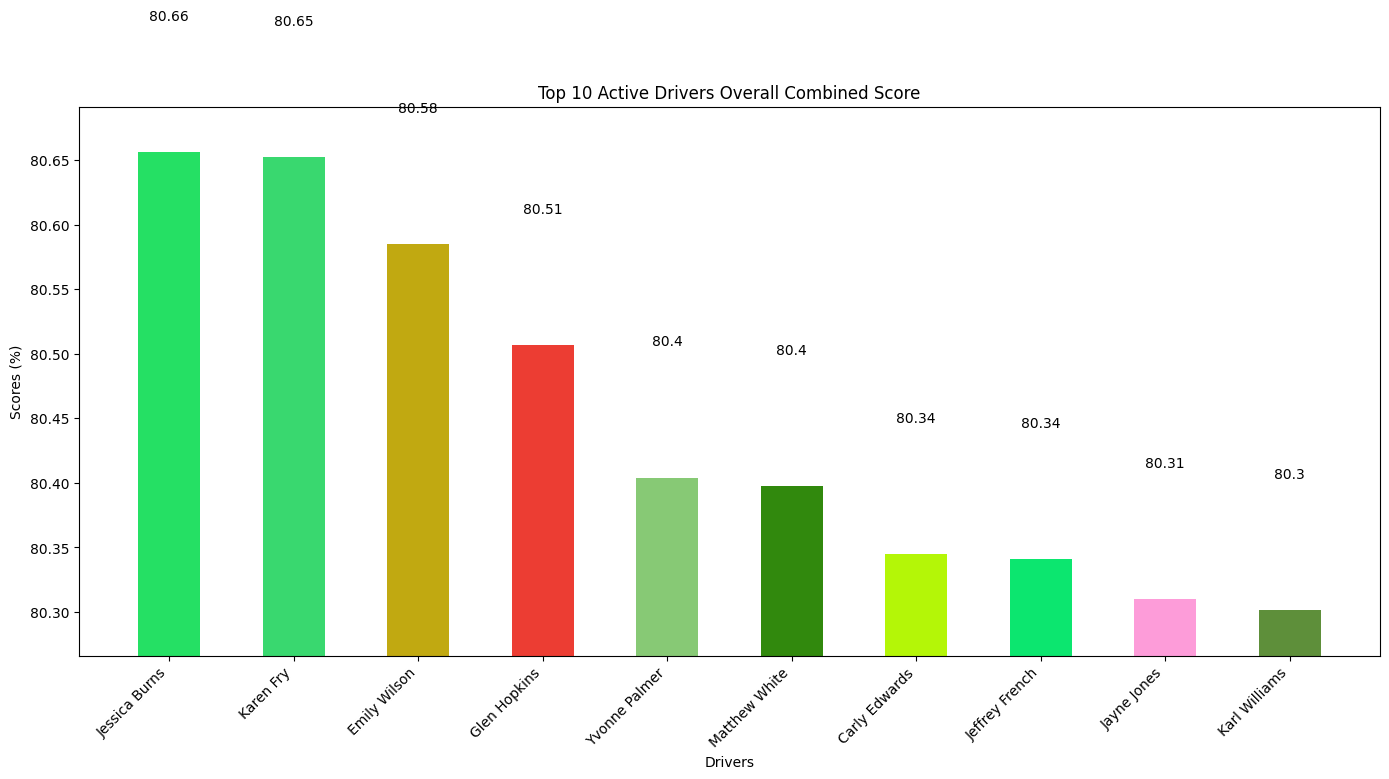

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [24]:
plot_driver_scores_combined(top_10_drivers)

In [25]:
report = dp.Report(
    dp.Text(report_header),
    dp.Text(methodology),
    dp.Text("## Data Table"),
    dp.DataTable(top_10_drivers),
    dp.Text("## Top 10 Active Drivers Overall Combined Score"),
    dp.Media(file="plot_driver_scores_combined.png"),
    dp.Text("## Top 10 Active Drivers by Overall Combined Score and the Pillars of Excellence"),
    dp.Media(file="plot_driver_scores_all_pillars.png"),
    dp.Text("## Customer Satisfaction (%)"),
    dp.Media(file="Customer Satisfaction (%)_plot.png"),
    dp.Text("## Experience Score (%)"),
    dp.Media(file="Experience Score (%)_plot.png"),
    dp.Text("## Operational (%)"),
    dp.Media(file="Operational (%)_plot.png"),
    dp.Text("## Recognition (%)"),
    dp.Media(file="Recognition (%)_plot.png")
)

In [26]:
# Save the report locally
dp.save_report(report, path="2a_report_top_10_active_drivers.html", open=True)


/usr/local/lib/python3.10/dist-packages/datapane/common/df_processor.py:26: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(df.index, pd.Int64Index):


App saved to ./2a_report_top_10_active_drivers.html